# P22 beamtime  in November 2018
# Overview

In [2]:
%load_ext autoreload
%autoreload 2
%gui tk

In [61]:
#Imports
# Embedded imports
import os, sys
import copy
import math
import matplotlib.pyplot as plt
from colorama import Fore
# Third party imports
import numpy as np
import pandas as pd
import scipy as sp
# Temporary solution for local imports
sys.path.append('..')
from xpstool import helpers 
from xpstool import Experiment, Spectrum, Region
from xpstool import Fitter

In [4]:
# Constants
p22_energy_3800 = 3800 # Photon energy from the p22 beamline
p22_energy_4600 = 4600 # Photon energy from the p22 beamline

In [5]:
# ---SCIENTA DATA FOLDERS---
# Full path to data files
data_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/Data"
# Full path to output files
output_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/ProcessedData"

file_names = []
file_idx = 0
for file in sorted(os.listdir(data_folder)):
    if file.endswith(".txt"):                         
        file_names.append(file)
        #print(f"---> file[{file_idx}]: {file}")
        file_idx += 1

**Files from 0000 to 0157 were measured at 4600 eV photon energy**

**File 0158 was measured at 3700 eV photon energy (IGNORE)**

**Files from 0159 to 0347 were measured at 3800 eV photon energy**

## <font color ='blue'>First experiment H2 : CO2 = 1 : 1 at ~50 mbar</font>

### Overview
**Incident angle = 0.75 deg** <br>
**Gas flow: 0.16 L/m CO2, 0.16 L/m H2** <br>
<font color ='red'>NOTE: (First measurement at RT was done at 50-60% higher pressure and different flow 0.3 L/m CO2, 0.3 L/m H2, 0.16 L/m He). Maybe it affects the intensity of the peaks for 25C.  </font> <br>

Analyser properties: <br>
>    Slit = 0.8 (?) <br>
    Pass energy: 100 <br>
    <br>
    Experimental broadening consists of Gaussian broadening and Lorentzian broadening. The Gaussian FWHM can be obtained from the Fermi edge. Lorentzian contribution should be relaxed for fitting.

In [203]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0002",
    "0014",
    "0019",
    "0024",
    "0029",
    "0034",
    "0039",
    "0044",
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0004", "0003", "0005", "0007"],
    ["0011", "0008", "0013", "0012"],
    ["0016", "0015", "0018", "0017"],
    ["0021", "0020", "0023", "0022"],
    ["0025", "0026", "0028", "0027"],
    ["0031", "0030", "0033", "0032"],
    ["0036", "0035", "0038", "0037"],
    ["0041", "0040", "0043", "0042"]
]
conditions = [
    {"Temperature": "25 C", "Pressure": "90 mbar"},
    {"Temperature": "150 C", "Pressure": "55-60 mbar"},
    {"Temperature": "200 C", "Pressure": "55-60 mbar"},
    {"Temperature": "250 C", "Pressure": "55-60 mbar"},
    {"Temperature": "300 C", "Pressure": "55-60 mbar"},
    {"Temperature": "350 C", "Pressure": "55-60 mbar"},
    {"Temperature": "400 C", "Pressure": "55-60 mbar"},
    {"Temperature": "450 C", "Pressure": "55-60 mbar"}
]

# Create an Experiment object to store spectra specified above
exp1 = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_4600)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp1.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_4600)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            exp1.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

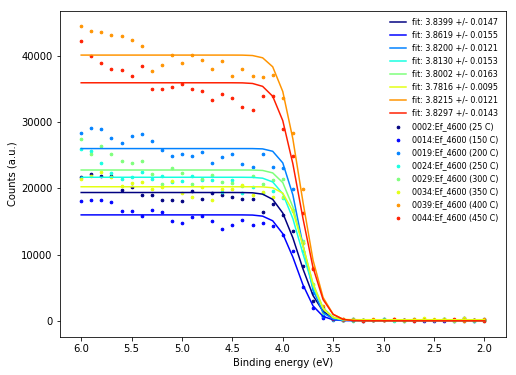

In [204]:
# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
valence_band = [] # Background level based on the valence band height (used for normalization)
fig = plt.figure(1, figsize=(8,6))
ax = plt.gca()

NUM_COLORS = len(fermi_nums)
cmap = plt.get_cmap('jet')
ax.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for fermi in fermi_nums:
    fermi_region = exp1.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       scatter=True, 
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 20000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, fit_parameters, add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    valence_band.append([np.abs(fit_res[0][0]), fit_res[1][0]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig.number,
                       ax=ax,
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)

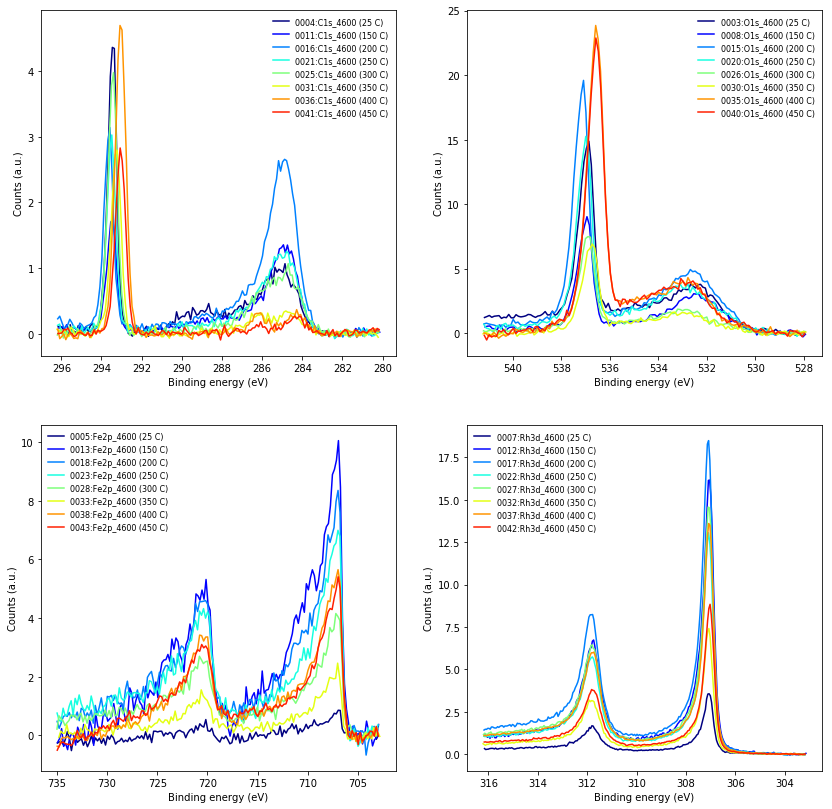

In [205]:
# Raw data overview (basic corrections)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
const_bg = [[283, 282], [529, 528], [705, 702], [305, 303]]

NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, single_set in enumerate(scan_sets): 
    for j, scan_num in enumerate(single_set):
        scan = exp1.getSpectrum(scan_num).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        scan.invertToBinding()
        helpers.normalize(scan, y_data="counts", const=valence_band[i][0], add_column=True)
        # Crop Fe2p regions
        if j == 2:
            scan.cropRegion(start=735, stop=703, changesource=True)
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(stop=528, changesource=True)

        # Shifting by backgrounds
        helpers.shiftByBackground(scan, const_bg[j], y_data="normalized", add_column=True)
        scan.makeFinalColumn("bgshifted", overwrite=True)
        
        # Plotting spectra
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="final", title=False)

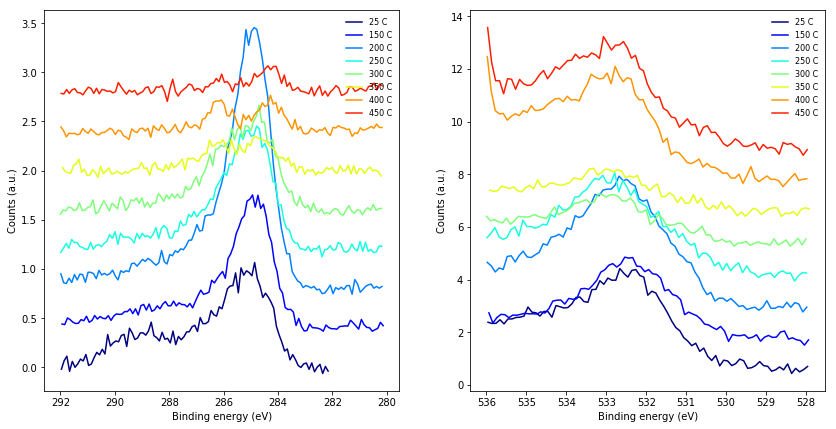

In [206]:
# Focusing on C1s and O1s regions
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
offset = [0.2, 0.6] # C1s, O1s

NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
for i, single_set in enumerate(scan_sets): 
    for j, scan_file in enumerate(single_set[0:2]):
        scan = exp1.getSpectrum(scan_file).getRegion()
        if j == 0:
            scan = scan.cropRegion(start=292)
        if j == 1:
            scan = scan.cropRegion(start=536)
        # Plotting spectra
        helpers.plotRegion(scan, 
                           figure=fig.number, 
                           ax=ax[j], 
                           y_offset=offset[j]*(2*i+j),
                           log_scale=False,
                           y_data="final", 
                           label=f"{scan.getConditions('Temperature')}", 
                           title=False)

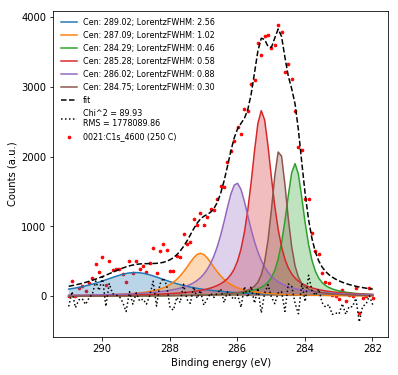

In [70]:
# Fitting

num = 3

fig = plt.figure(1, figsize=(6,6))
scan = exp1.getSpectrum(scan_sets[num][0]).getRegion().cropRegion(start=291)
#scan = scan.cropRegion(start=292.5)
fitter = Fitter(scan, 
                y_data="final", 
                gauss_fwhm=gauss_fwhms[num][0])
initial_guess = [ # amp, cen, fwhm
#    1, 293.3, 0.3,
    100, 290, 1,
    100, 288.5, 1,
   1000, 284, 1,
#   1000, 284.7, 1,
    2000, 286.2, 1,
    600, 287, 1,
   2000, 285.7, 1
    #500, 287.7, 2
]
fix_parameters = {
    "amp": [],
    "cen": [],
    "fwhm": []
}
fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
#print(fitter)
helpers.plotRegion(scan, 
                   y_data="final", 
                   color='red', 
                   scatter=True, 
                   legend_pos='best', 
                   title=False)
for peak in fitter.getPeaks():
    helpers.plotPeak(peak, legend_pos='lower center')
helpers.plotFit(fitter, addresiduals=True, legend_pos='best')
scan.addFitter(fitter, overwrite=True)

In [ ]:
# Fitting of the experiment
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,30))
offset_C1s = 10000
offset_O1s = 3000
# Populate C1s spectra
for i, set_ in enumerate(scan_sets):    
    scan = exp1.getSpectrum(set_[0]).getRegion().cropRegion(start=292)
    fitter = Fitter(scan, 
                    y_data="final", 
                    gauss_fwhm=gauss_fwhms[i][0])
    if i < 4:
        initial_guess = [ # amp, cen, fwhm
#            5000, 293.3, 0.3,
            10000, 284.6, 1,
            10000, 285.2, 1,
            100, 286.2, 1,
            100, 287, 1
        ] 
    if i >= 4 and i < 6:
        initial_guess = [ # amp, cen, fwhm
#            5000, 293.3, 0.3,
            1000, 284.6, 1,
            1000, 285.2, 1,
            100, 286.2, 1
        ]        
    if i >=6:
        initial_guess = [ # amp, cen, fwhm
#            5000, 293.3, 0.3,
            100, 284.7, 1,
            100, 286.2, 1
        ]
    fix_parameters = {
        "amp": [],
        "cen": [],
        "fwhm": [],
    }
    helpers.plotRegion(scan, 
                       y_offset=offset_C1s*i, 
                       figure=fig.number, 
                       ax=ax1, 
                       legend=False, 
                       y_data="final", 
                       color='red', 
                       scatter=True,
                       title=False)
    if i < len(scan_sets):
        fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
        #print(fitter)
        for peak in fitter.getPeaks():
            helpers.plotPeak(peak, 
                             y_offset=offset_C1s*i, 
                             figure=fig.number,
                             color="blue",
                             ax=ax1,
                             fill=True,
                             legend=False)
        helpers.plotFit(fitter, 
                        y_offset=offset_C1s*i, 
                        figure=fig.number, 
                        ax=ax1, 
                        legend=False, 
                        addresiduals=True)
        scan.addFitter(fitter, overwrite=True)
# Populate O1s spectra
for i, set_ in enumerate(scan_sets):    
    scan = exp1.getSpectrum(set_[1]).getRegion().cropRegion(start=537)
    fitter = Fitter(scan, 
                    y_data="final", 
                    gauss_fwhm=gauss_fwhms[i][0])
    initial_guess = [ # amp, cen, fwhm
#        20000, 537, 0.5,
        5000, 532.59, 1,
        5000, 533.91, 1,
        1000, 535, 1,
        1000, 535.6, 1
    ]
    fix_parameters = {
        "amp": [],
        "cen": [],
        "fwhm": [],
    }
    helpers.plotRegion(scan, 
                       y_offset=offset_O1s*i, 
                       figure=fig.number, 
                       ax=ax2, 
                       legend=False, 
                       y_data="final", 
                       color='red', 
                       scatter=True,
                       title=False)
    if i < len(scan_sets):
        fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
        #print(fitter)
        for peak in fitter.getPeaks():
            helpers.plotPeak(peak, 
                             y_offset=offset_O1s*i, 
                             figure=fig.number,
                             color="green",
                             ax=ax2,
                             fill=True,
                             legend=False)
        helpers.plotFit(fitter, 
                        y_offset=offset_O1s*i, 
                        figure=fig.number, 
                        ax=ax2, 
                        legend=False, 
                        addresiduals=True)
        scan.addFitter(fitter, overwrite=True)

## <font color ='blue'>Second experiment H2 : CO2 = 4 : 1 at ~60 mbar</font>

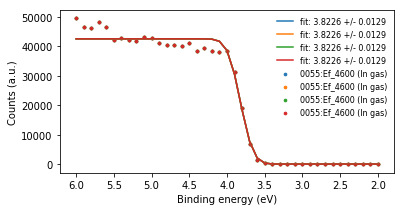

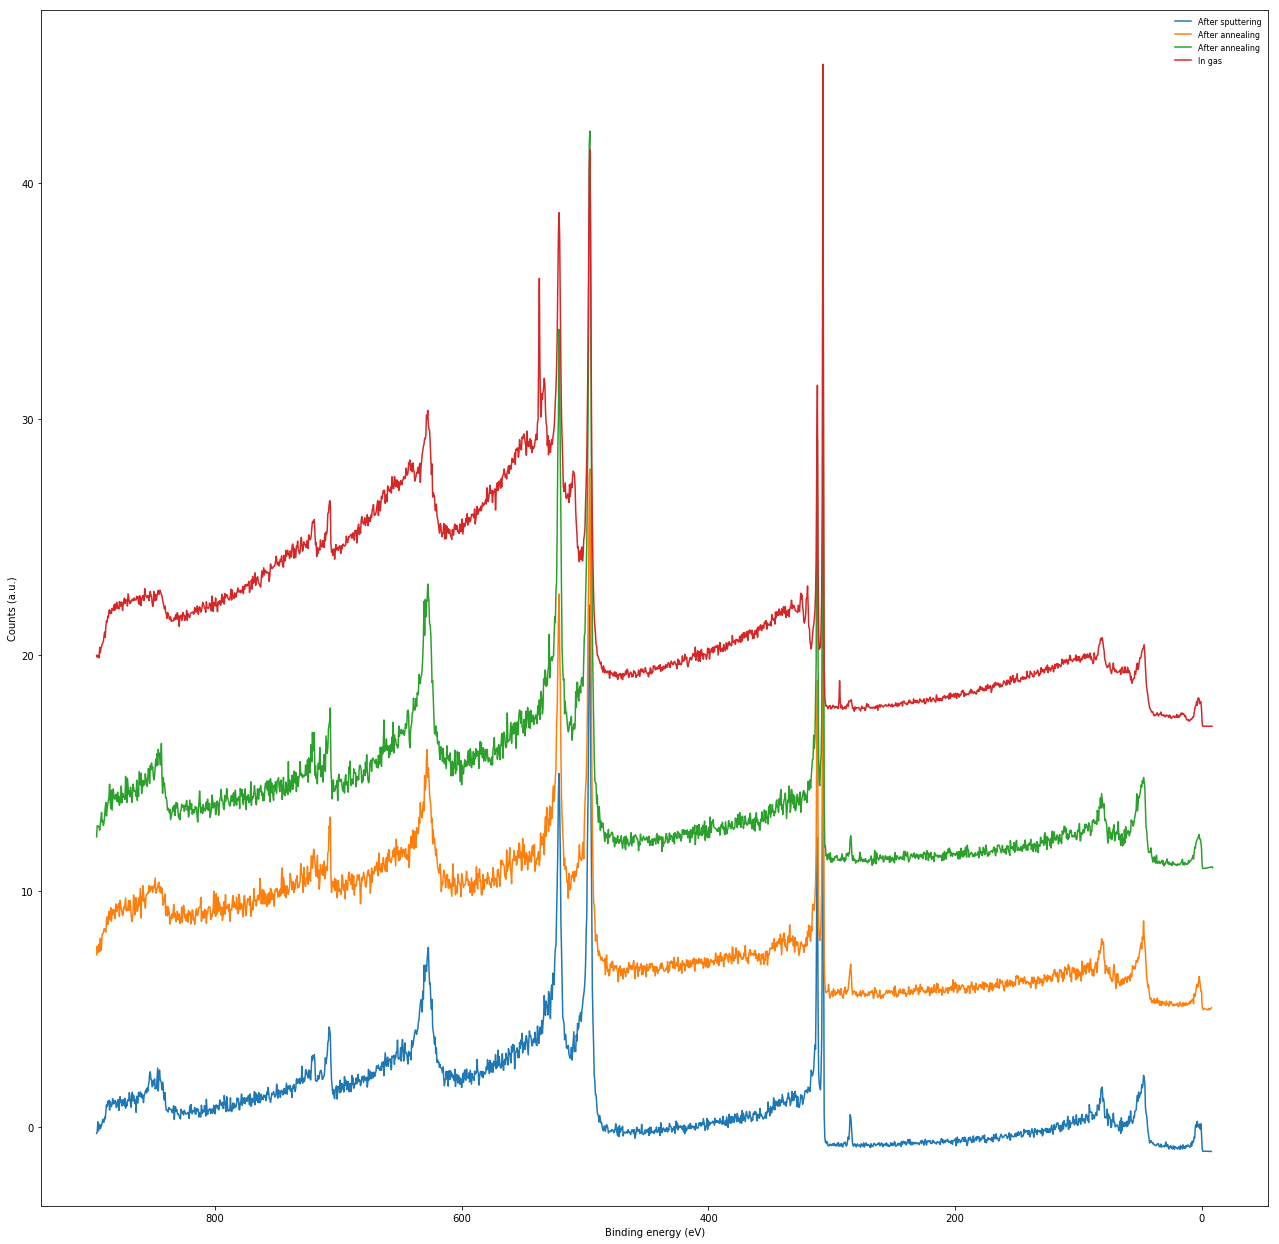

In [41]:
# Three surveys spectra 
# 1: after sputtering (no annealing), 
# 2: after additional annealing at 800C for 5 min, 
# 3: in the agseous atmosphere (0.16 L/min CO2 + 0.64 L/min H2)

%matplotlib inline 
# %matplotlib qt

# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0055",
    "0055",
    "0055",
    "0055"
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0045"],
    ["0046"],
    ["0047"],
    ["0048"]
]
conditions = [
    {"Conditions": "After sputtering"},
    {"Conditions": "After annealing"},
    {"Conditions": "After annealing"},
    {"Conditions": "In gas"}
]

# Create an Experiment object to store spectra specified above
surveys = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_4600)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        surveys.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_4600)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            surveys.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
valence_band = [] # Background level based on the valence band height (used for normalization)
const_bg = [1, -10]
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(22,22))
for fermi in fermi_nums:
    fermi_region = surveys.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig1.number,
                       ax=ax1,
                       scatter=True,
                       label=f"{fermi_region.getID()} ({fermi_region.getConditions()['Conditions']})",
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 20000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, fit_parameters, add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    valence_band.append([np.abs(fit_res[0][0]), fit_res[1][0]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig1.number,
                       ax=ax1,
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)
for i, single_set in enumerate(scan_sets): 
    for j, scan_file in enumerate(single_set):
        scan = surveys.getSpectrum(scan_file).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        scan.invertToBinding()      
        # Taking average of the lower binding energy tail to normalize, since the Fermi level was measured
        # only once and doesn't give correct background value for all spectra.
        tail = scan.getData("counts")[-20:-9]
        shift = scan.getData("energy")[-20:-9]
        helpers.normalize(scan, y_data="counts", const=np.mean(tail), add_column=True)
        # Shifting by backgrounds
        helpers.shiftByBackground(scan, [shift[0], shift[-1]], y_data="normalized", add_column=True)
        scan.makeFinalColumn("bgshifted", overwrite=True)
        # Plotting spectra
        helpers.plotRegion(scan, 
                           figure=fig2.number, 
                           ax=ax2, 
                           y_offset=3*(2*i+j),
                           log_scale=False,
                           y_data="final", 
                           label=f"{scan.getConditions('Conditions')}", 
                           title=False)
        #display(scan.getData())

In [43]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0055",
    "0061",
    "0066",
    "0071",
    "0077",
    "0082",
    "0087",
    "0092",
    "0092 copy", # Same Fermi level goes for the last five runs
    "0092 copy 2",
    "0092 copy 3",
    "0092 copy 4",
    "0092 copy 5"
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0052", "0051", "0054", "0053"],
    ["0058", "0056", "0060", "0059"],
    ["0063", "0062", "0065", "0064"],
    ["0068", "0067", "0070", "0069"],
    ["0074", "0073", "0076", "0075"],
    ["0079", "0078", "0081", "0080"],
    ["0084", "0083", "0086", "0085"],
    ["0089", "0088", "0091", "0090"],
    ["0094"], # Only C1s spectra were taken for the last five runs
    ["0095"],
    ["0096"],
    ["0098"],
    ["0099"]
]
conditions = [
    {"Temperature": "25 C"},
    {"Temperature": "150 C"},
    {"Temperature": "200 C"},
    {"Temperature": "250 C"},
    {"Temperature": "300 C"},
    {"Temperature": "350 C"},
    {"Temperature": "400 C"},
    {"Temperature": "450 C"},
    {"Temperature": "250 C cooling"},
    {"Temperature": "200 C cooling"},
    {"Temperature": "150 C cooling"},
    {"Temperature": "150 C stop CO2"},
    {"Temperature": "250 C original conditions"}
]

# Create an Experiment object to store spectra specified above
exp2 = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_4600)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp2.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_4600)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            exp2.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

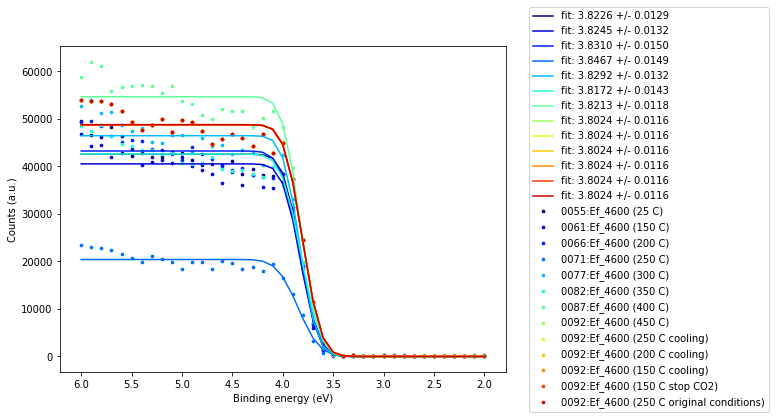

In [44]:
# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
valence_band = [] # Background level based on the valence band height (used for normalization)
fig = plt.figure(1, figsize=(8,6))
ax = plt.gca()

NUM_COLORS = len(fermi_nums)
cmap = plt.get_cmap('jet')
ax.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for fermi in fermi_nums:
    fermi_region = exp2.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       scatter=True, 
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 20000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, 
                                   fit_parameters, 
                                   add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    valence_band.append([np.abs(fit_res[0][0]), fit_res[1][0]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)
legend = plt.gca().legend(loc='center right', bbox_to_anchor = (1.6, 0.5))

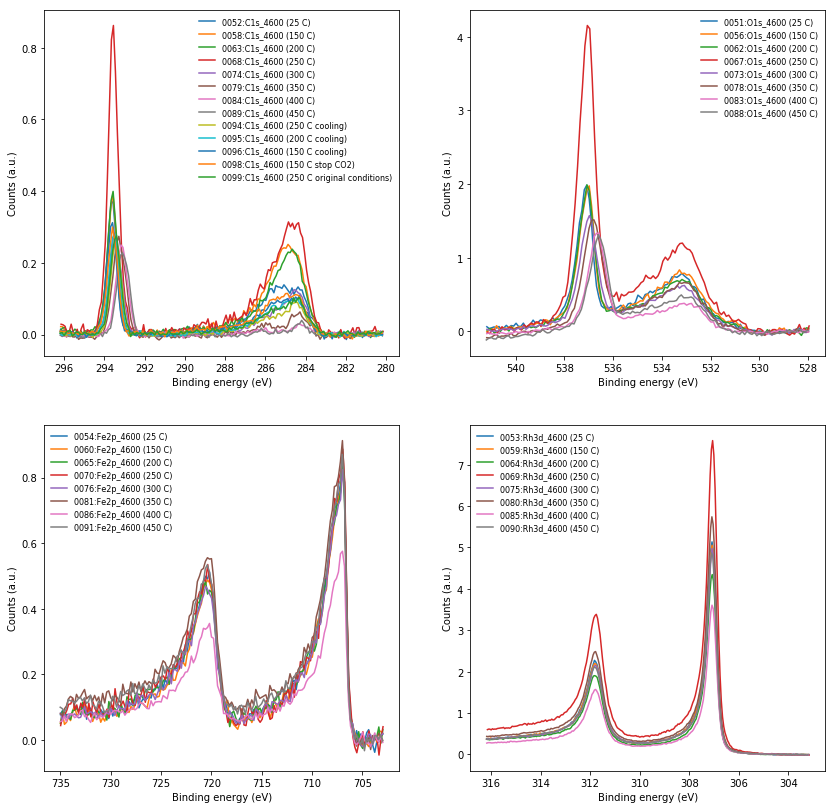

In [46]:
# Raw data overview
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
const_bg = [[283, 282], [529, 528], [705, 702], [305, 303]]

# NUM_COLORS = len(scan_sets)
# cmap = plt.get_cmap('jet')
# for axis in ax:
#     axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, single_set in enumerate(scan_sets): 
    for j, scan_num in enumerate(single_set):
        scan = exp2.getSpectrum(scan_num).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()
        
        helpers.normalize(scan, y_data="counts", const=valence_band[i][0], add_column=True)
        # Crop Fe2p regions
        if j == 2:
            scan.cropRegion(start=735, stop=703, changesource=True)
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(stop=528, changesource=True)
        
        # Shifting by backgrounds
        helpers.shiftByBackground(scan, const_bg[j], y_data="normalized", add_column=True)
        scan.makeFinalColumn("bgshifted", overwrite=True)

        # Plotting spectra
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="final", title=False)

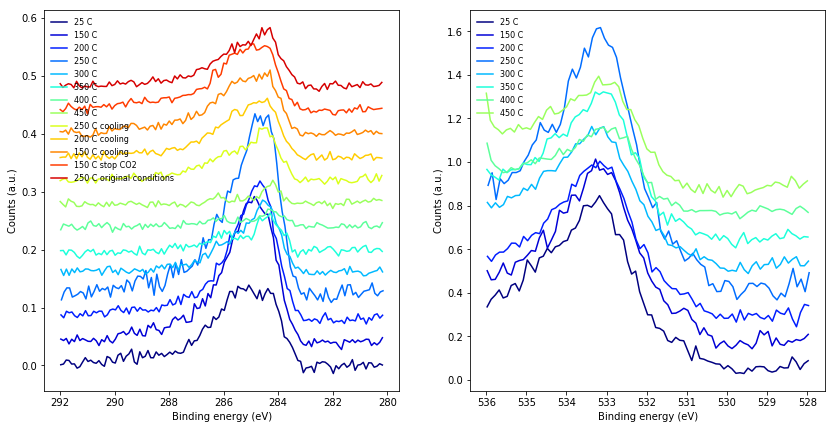

In [48]:
# Focusing on C1s and O1s regions
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = [ax1, ax2]
offset = [0.02, 0.06] # C1s, O1s

NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
for i, single_set in enumerate(scan_sets): 
    for j, scan_file in enumerate(single_set[0:2]):
        scan = exp2.getSpectrum(scan_file).getRegion()
        
        if j == 0:
            scan = scan.cropRegion(start=292)
        if j == 1:
            scan = scan.cropRegion(start=536)
        # Plotting spectra
        helpers.plotRegion(scan, 
                           figure=fig.number, 
                           ax=ax[j], 
                           y_offset=offset[j]*(2*i+j),
                           log_scale=False,
                           y_data="final", 
                           label=f"{scan.getConditions('Temperature')}",
                           legend_pos="upper left",
                           title=False)

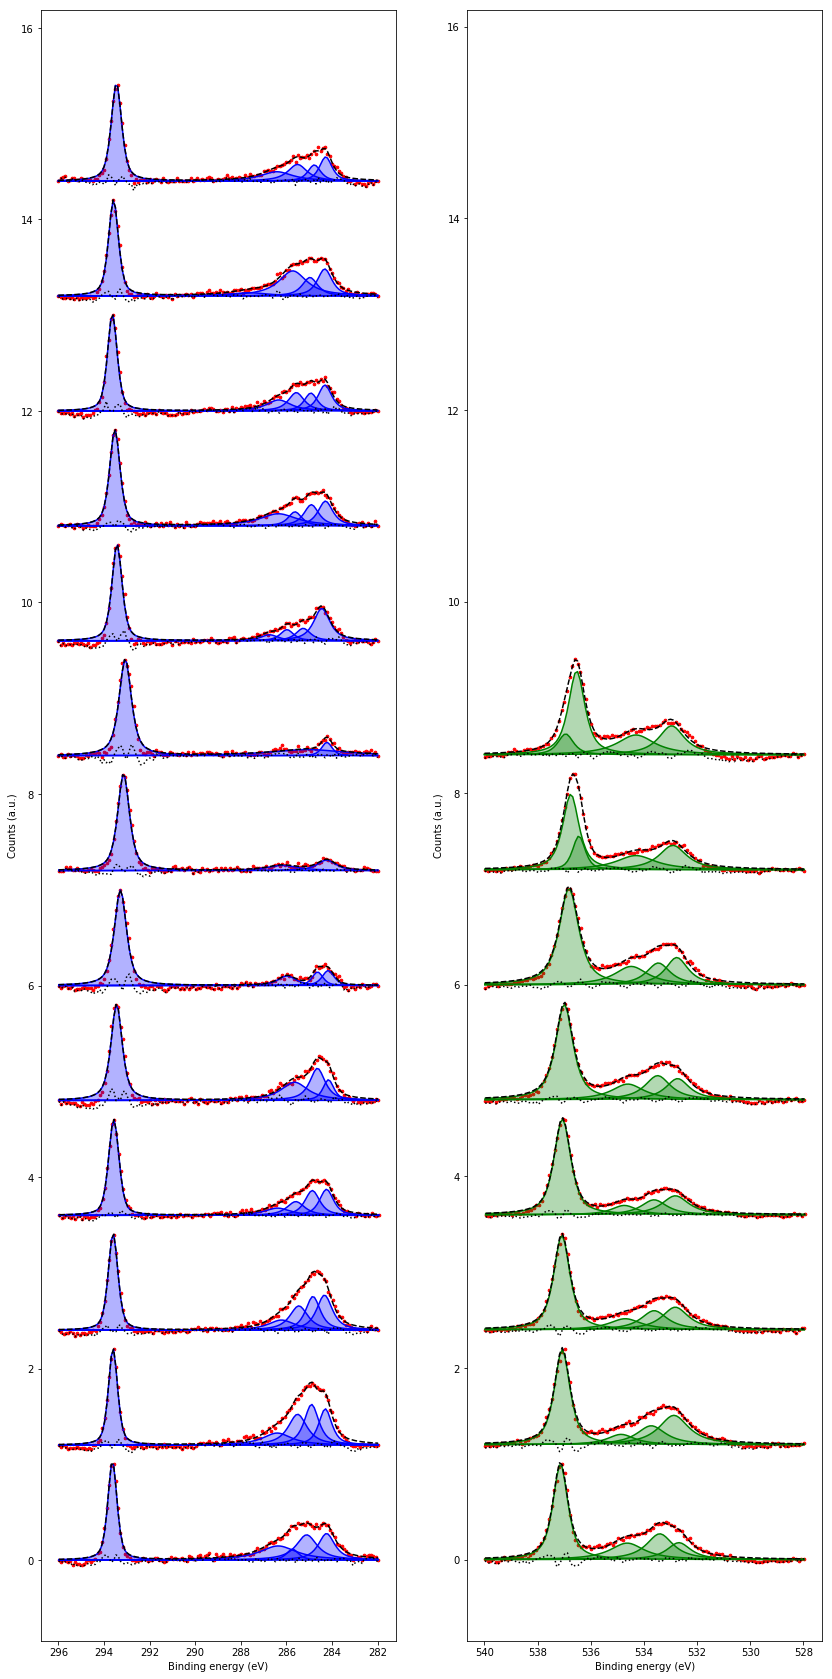

In [20]:
# Fitting of the experiment
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,30))
# Populate C1s spectra
for i, set_ in enumerate(scan_sets):    
    scan = exp2.getSpectrum(set_[0]).getRegion()
    fitter = Fitter(scan, 
                    y_data="final", 
                    gauss_fwhm=gauss_fwhms[i][0])
    if i < 4 or i >=8:
        initial_guess = [ # amp, cen, fwhm
            1, 293.3, 0.3,
            0.3, 284.6, 1,
            0.3, 285.2, 1,
            0.3, 286.2, 1,
            0.3, 287, 1
        ] 
    if i >= 4 and i < 6:
        initial_guess = [ # amp, cen, fwhm
            1, 293.3, 0.3,
            0.3, 284.6, 1,
            0.3, 285.2, 1,
            0.3, 286.2, 1
        ]        
    if i >= 6 and i < 8:
        initial_guess = [ # amp, cen, fwhm
            1, 293.3, 0.3,
            0.1, 284.7, 1,
            0.1, 286.2, 1
        ]
    fix_parameters = {
        "amp": [],
        "cen": [],
        "fwhm": [],
    }
    helpers.plotRegion(scan, 
                       y_offset=1.2*i, 
                       figure=fig.number, 
                       ax=ax1, 
                       legend=False, 
                       y_data="final", 
                       color='red', 
                       scatter=True,
                       title=False)
    if i < len(scan_sets):
        fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
        #print(fitter)
        for peak in fitter.getPeaks():
            helpers.plotPeak(peak, 
                             y_offset=1.2*i, 
                             figure=fig.number,
                             color="blue",
                             ax=ax1,
                             fill=True,
                             legend=False)
        helpers.plotFit(fitter, 
                        y_offset=1.2*i, 
                        figure=fig.number, 
                        ax=ax1, 
                        legend=False, 
                        addresiduals=True)
        scan.addFitter(fitter, overwrite=True)
# Populate O1s spectra
for i, set_ in enumerate(scan_sets):
    if len(set_) < 2: # If only C1s spectra, don't try to plot O1s
        plt.plot([533], [1+1.2*i]) # To align the spectra along the vertical axis
        continue
    scan = exp2.getSpectrum(set_[1]).getRegion()
    fitter = Fitter(scan, 
                    y_data="final", 
                    gauss_fwhm=gauss_fwhms[i][0])
    initial_guess = [ # amp, cen, fwhm
        1, 537, 0.5,
        0.3, 532.59, 1,
        0.3, 533.91, 1,
        0.3, 535.6, 1
    ]
    fix_parameters = {
        "amp": [],
        "cen": [],
        "fwhm": [],
    }
    helpers.plotRegion(scan, 
                       y_offset=1.2*i, 
                       figure=fig.number, 
                       ax=ax2, 
                       legend=False, 
                       y_data="final", 
                       color='red', 
                       scatter=True,
                       title=False)
    if i < len(scan_sets):
        fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
        #print(fitter)
        for peak in fitter.getPeaks():
            helpers.plotPeak(peak, 
                             y_offset=1.2*i, 
                             figure=fig.number,
                             color="green",
                             ax=ax2,
                             fill=True,
                             legend=False)
        helpers.plotFit(fitter, 
                        y_offset=1.2*i, 
                        figure=fig.number, 
                        ax=ax2, 
                        legend=False, 
                        addresiduals=True)
        scan.addFitter(fitter, overwrite=True)

## <font color ='blue'>Third experiment H2 : CO2 = 4 : 1 at ~150 mbar</font>

In [49]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0104",
    "0109",
    "0115",
    "0120",
    "0125"
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0101", "0100", "0103", "0102"],
    ["0106", "0105", "0108", "0107"],
    ["0112", "0111", "0114", "0113"],
    ["0117", "0116", "0119", "0118"],
    ["0122", "0121", "0124", "0123"]
]
conditions = [
    {"Temperature": "250 C"},
    {"Temperature": "300 C"},
    {"Temperature": "350 C"},
    {"Temperature": "400 C"},
    {"Temperature": "450 C"}
]

# Create an Experiment object to store spectra specified above
exp3 = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_4600)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp3.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_4600)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            exp3.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

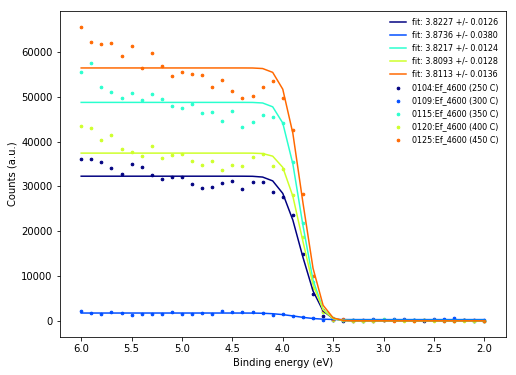

In [50]:
# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
valence_band = [] # Background level based on the valence band height (used for normalization)
fig = plt.figure(1, figsize=(8,6))
ax = plt.gca()

NUM_COLORS = len(fermi_nums)
cmap = plt.get_cmap('jet')
ax.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for fermi in fermi_nums:
    fermi_region = exp3.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       scatter=True, 
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 20000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, 
                                   fit_parameters, 
                                   add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    valence_band.append([np.abs(fit_res[0][0]), fit_res[1][0]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)

NOTE: Normalized by C1s lower BE tail


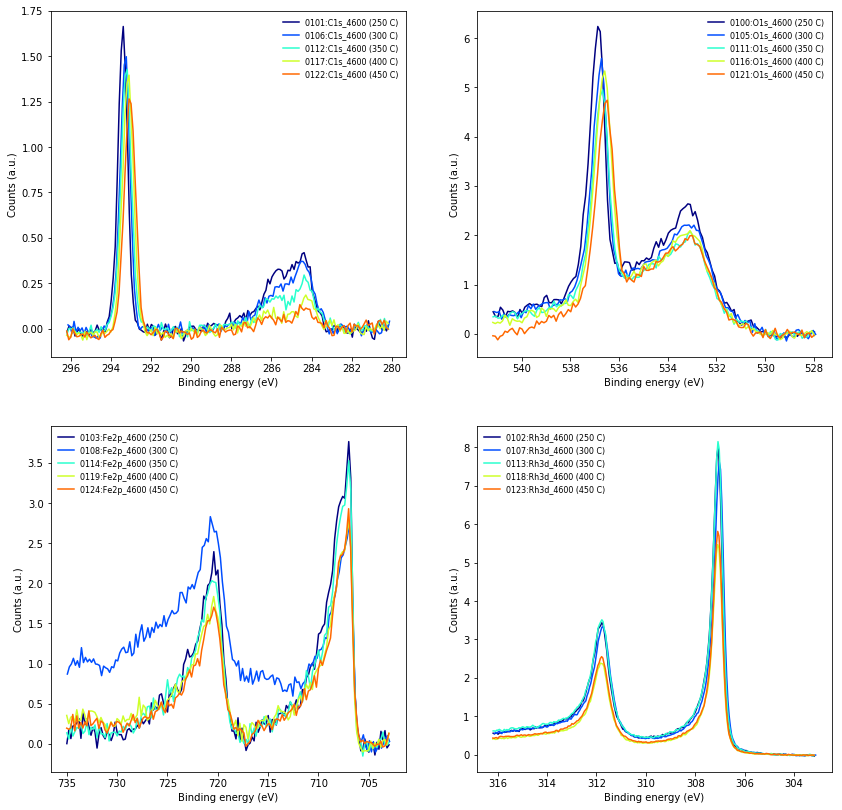

In [62]:
# Raw data overview (basic corrections, NOTE: Normalized by C1s lower BE tail)
print(Fore.RED + "NOTE: Normalized by C1s lower BE tail")
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
const_bg = [[283, 282], [529, 528], [705, 702], [305, 303]]

NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, single_set in enumerate(scan_sets): 
    normalization_const = 0 # Something fishy with Fermi edges, so we normalize by C1s lower BE tail
    for j, scan_num in enumerate(single_set):
        scan = exp3.getSpectrum(scan_num).getRegion()
        if j == 0:
            normalization_const = np.mean(scan.getData("counts")[-10: -1])
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        scan.invertToBinding()
        helpers.normalize(scan, y_data="counts", const=normalization_const, add_column=True)
        # Crop Fe2p regions
        if j == 2:
            scan.cropRegion(start=735, stop=703, changesource=True)
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(stop=528, changesource=True)

        # Shifting by backgrounds
        helpers.shiftByBackground(scan, const_bg[j], y_data="normalized", add_column=True)
        scan.makeFinalColumn("bgshifted", overwrite=True)
        
        # Plotting spectra
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="final", title=False)

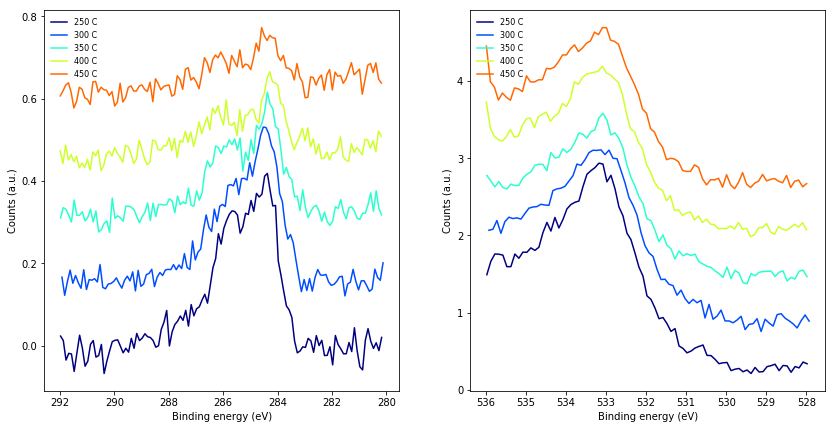

In [60]:
# Focusing on C1s and O1s regions
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = [ax1, ax2]
offset = [0.08, 0.3] # C1s, O1s

NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
for i, single_set in enumerate(scan_sets): 
    for j, scan_file in enumerate(single_set[0:2]):
        scan = exp3.getSpectrum(scan_file).getRegion()
        
        if j == 0:
            scan = scan.cropRegion(start=292)
        if j == 1:
            scan = scan.cropRegion(start=536)
        # Plotting spectra
        helpers.plotRegion(scan, 
                           figure=fig.number, 
                           ax=ax[j], 
                           y_offset=offset[j]*(2*i+j),
                           log_scale=False,
                           y_data="final", 
                           label=f"{scan.getConditions('Temperature')}",
                           legend_pos="upper left",
                           title=False)

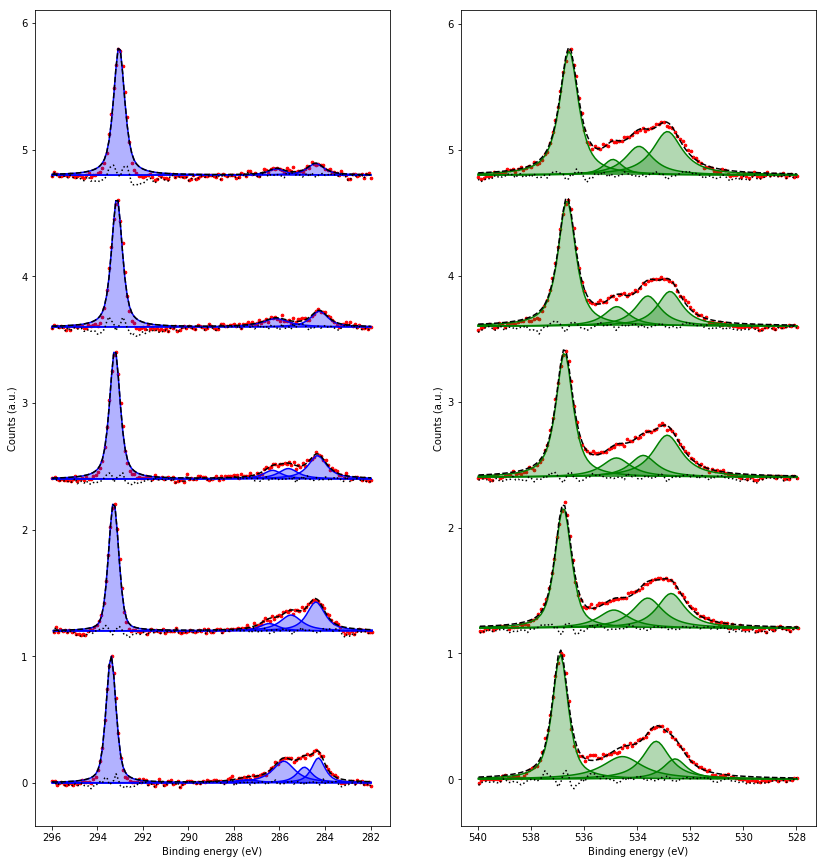

In [25]:
# Fitting of the desorption experiment
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,15))
# Populate C1s spectra
for i, set_ in enumerate(scan_sets):    
    scan = exp3.getSpectrum(set_[0]).getRegion()
    fitter = Fitter(scan, 
                    y_data="final", 
                    gauss_fwhm=gauss_fwhms[i][0])
    if i < 1:
        initial_guess = [ # amp, cen, fwhm
            1, 293.3, 0.3,
            0.3, 284.6, 1,
            0.3, 285.2, 1,
            0.3, 286.2, 1,
            0.3, 287, 1
        ] 
    if i >= 1 and i < 3:
        initial_guess = [ # amp, cen, fwhm
            1, 293.3, 0.3,
            0.3, 284.6, 1,
            0.3, 285.2, 1,
            0.3, 286.2, 1
        ]        
    if i >=3:
        initial_guess = [ # amp, cen, fwhm
            1, 293.3, 0.3,
            0.1, 284.7, 1,
            0.1, 286.2, 1
        ]
    fix_parameters = {
        "amp": [],
        "cen": [],
        "fwhm": [],
    }
    helpers.plotRegion(scan, 
                       y_offset=1.2*i, 
                       figure=fig.number, 
                       ax=ax1, 
                       legend=False, 
                       y_data="final", 
                       color='red', 
                       scatter=True,
                       title=False)
    if i < len(scan_sets):
        fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
        #print(fitter)
        for peak in fitter.getPeaks():
            helpers.plotPeak(peak, 
                             y_offset=1.2*i, 
                             figure=fig.number,
                             color="blue",
                             ax=ax1,
                             fill=True,
                             legend=False)
        helpers.plotFit(fitter, 
                        y_offset=1.2*i, 
                        figure=fig.number, 
                        ax=ax1, 
                        legend=False, 
                        addresiduals=True)
        scan.addFitter(fitter, overwrite=True)
# Populate O1s spectra
for i, set_ in enumerate(scan_sets):
    scan = exp3.getSpectrum(set_[1]).getRegion()
    fitter = Fitter(scan, 
                    y_data="final", 
                    gauss_fwhm=gauss_fwhms[i][0])
    initial_guess = [ # amp, cen, fwhm
        1, 537, 0.5,
        0.3, 532.59, 1,
        0.3, 533.91, 1,
        0.3, 535, 1
    ]
    fix_parameters = {
        "amp": [],
        "cen": [],
        "fwhm": [],
    }
    helpers.plotRegion(scan, 
                       y_offset=1.2*i, 
                       figure=fig.number, 
                       ax=ax2, 
                       legend=False, 
                       y_data="final", 
                       color='red', 
                       scatter=True,
                       title=False)
    if i < len(scan_sets):
        fitter.fitVoigt(initial_guess, fix_pars=fix_parameters)
        #print(fitter)
        for peak in fitter.getPeaks():
            helpers.plotPeak(peak, 
                             y_offset=1.2*i, 
                             figure=fig.number,
                             color="green",
                             ax=ax2,
                             fill=True,
                             legend=False)
        helpers.plotFit(fitter, 
                        y_offset=1.2*i, 
                        figure=fig.number, 
                        ax=ax2, 
                        legend=False, 
                        addresiduals=True)
        scan.addFitter(fitter, overwrite=True)

## <font color ='blue'>Forth experiment switching from H2 : CO2 4 : 1 to H2 : CO 1 : 1 at ~150 mbar</font>

In [62]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0130",
    "0135",
    "0142",
    "0142 copy"
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0127", "0126", "0129", "0128"],
    ["0132", "0131", "0134", "0133"],
    ["0140", "0141", "0137", "0138"],
    ["0143"]
]
conditions = [
    {"Temperature": "25 C H2:CO2 4:1"},
    {"Temperature": "25 C H2:CO 1:1"},
    {"Temperature": "100 C H2:CO 1:1"},
    {"Temperature": "150 C H2:CO 1:1"}
]

# Create an Experiment object to store spectra specified above
exp4 = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_4600)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp4.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_4600)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            exp4.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

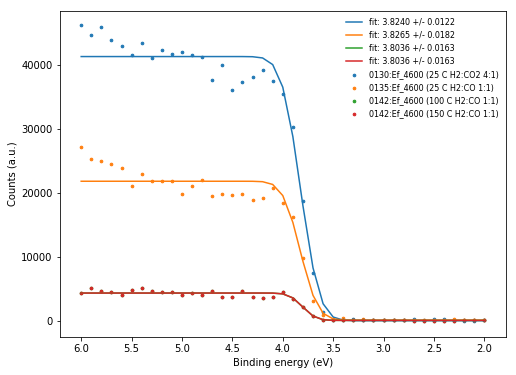

In [63]:
# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
fig = plt.figure(1, figsize=(8,6))
for fermi in fermi_nums:
    fermi_region = exp4.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       scatter=True, 
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 20000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, 
                                   fit_parameters, 
                                   add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)

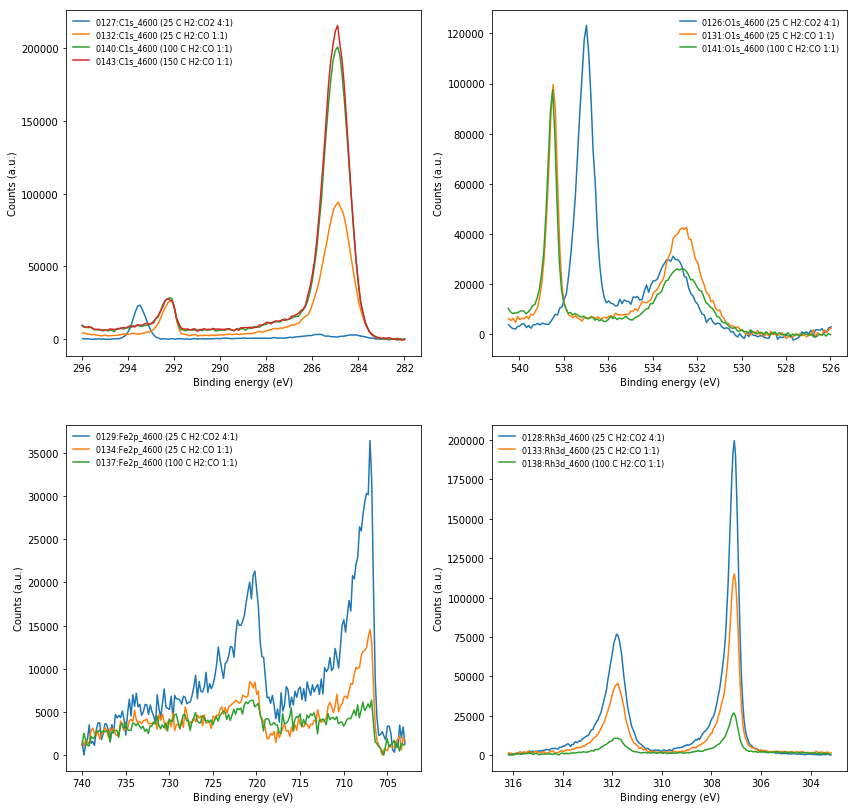

In [64]:
# Adjusting and plotting data overview
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
for i, single_set in enumerate(scan_sets): 
    for j, scan_num in enumerate(single_set):
        scan = exp4.getSpectrum(scan_num).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()
        # Crop Fe2p regions
        if j == 2:
            scan.cropRegion(start=740, stop=703, changesource=True)
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(start=540.5, stop=526, changesource=True)
        # Crop C1s regions
        if j == 0:
            scan.cropRegion(start=296, stop=282, changesource=True)
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
        if j > 1:
            helpers.calculateShirley(scan, y_data="counts", add_column=True)
            scan.makeFinalColumn("shirleyBG", overwrite=True)
        else:
            if j == 0:
                helpers.shiftByBackground(scan, start=282.5, stop=282, y_data="counts", add_column=True)
            if j == 1:
                helpers.shiftByBackground(scan, start=529, stop=526, y_data="counts", add_column=True)
            scan.makeFinalColumn("bgshifted", overwrite=True)
        # Plotting spectra
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="final", title=False)

## <font color ='blue'>Fifth experiment He : CO : O2 = 17 : 2 : 1 at ~450 mbar</font>

In [123]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0167",
    "0172",
    "0179",
    "0185",
    "0190",
    "0190 copy"
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0165", "0162", "0163", "0164"],
    ["0170", "0171", "0169", "0168"],
    ["0177", "0178", "0176", "0173"],
    ["0182", "0181", "0184", "0183"],
    ["0187", "0186", "0189", "0188"],
    ["0192", "0191", "0193", "0195"]
]
conditions = [
    {"Temperature": "270 C"},
    {"Temperature": "300 C"},
    {"Temperature": "350 C"},
    {"Temperature": "350 C more O2"},
    {"Temperature": "350 C 1:1"},
    {"Temperature": "350 C only CO"}
]

# Create an Experiment object to store spectra specified above
exp5 = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_3800)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp5.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_3800)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            exp5.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

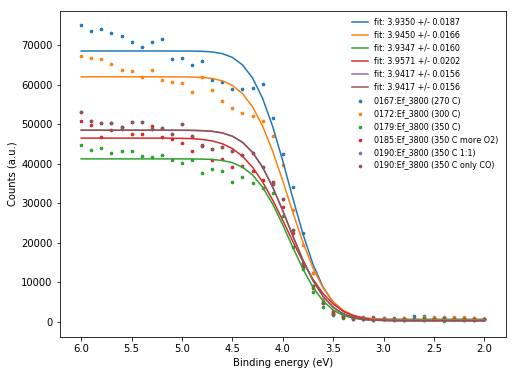

In [124]:
# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
fig = plt.figure(1, figsize=(8,6))
for fermi in fermi_nums:
    fermi_region = exp5.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       scatter=True, 
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 60000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, 
                                   fit_parameters, 
                                   add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)

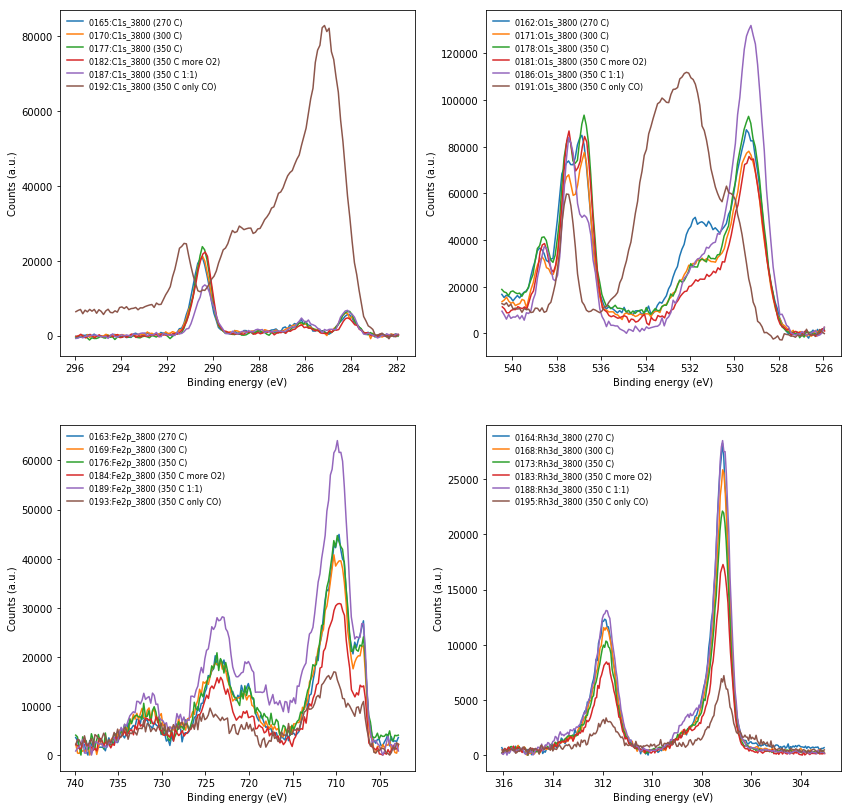

In [125]:
# Adjusting and plotting data overview
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
for i, single_set in enumerate(scan_sets): 
    for j, scan_num in enumerate(single_set):
        scan = exp5.getSpectrum(scan_num).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()        
        # Crop Fe2p regions
        if j == 2:
            scan.cropRegion(start=740, stop=703, changesource=True)        
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(start=540.5, stop=526, changesource=True)
            helpers.shiftByBackground(scan, start=527, stop=526, y_data="counts", add_column=True)
        # Crop C1s regions
        if j == 0:
            scan.cropRegion(start=296, stop=282, changesource=True)
            helpers.shiftByBackground(scan, start=283, stop=282, y_data="counts", add_column=True)
        # Calculating backgrounds
        if j > 1:
            helpers.calculateShirley(scan, y_data="counts", add_column=True)
            scan.makeFinalColumn("shirleyBG", overwrite=True)
        else:
            scan.makeFinalColumn("bgshifted", overwrite=True)        
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
        helpers.calculateShirley(scan, y_data="counts", add_column=True)
        helpers.calculateLinearBackground(scan, y_data="shirleyBG", add_column=True)
        # Plotting spectra
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="final", title=False)

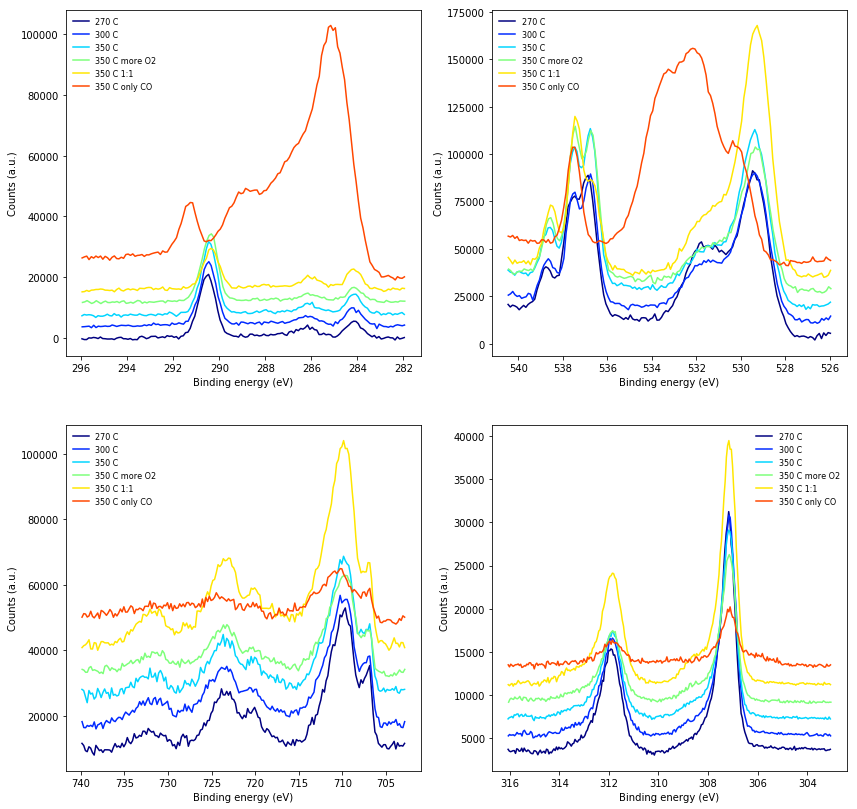

In [130]:
# Focusing on C1s and O1s regions
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
offset = [2000, 4000, 4000, 1000]
# Make sure that the colors are consistent through the experiment and that they
# are not repeated
NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i, single_set in enumerate(scan_sets): 
    for j, scan_file in enumerate(single_set):
        scan = exp5.getSpectrum(scan_file).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
        #helpers.calculateShirley(scan, y_data="counts", add_column=True)
#         if j == 0:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[296,294],[282.5,282]],
#                                   add_column=True)      
#         if j == 1:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[540.5,540],[527,526]],
#                                   add_column=True) 
#         if j == 2:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[740,738],[705,704]],
#                                   add_column=True) 
#         if j == 3:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[316,315],[304,303]],
#                                   add_column=True) 
        #helpers.calculateLinearBackground(scan, y_data="linearBG", add_column=True)
#         helpers.normalize(scan, y_data="linearBG", add_column=True)
#         scan.makeFinalColumn("normalized", overwrite=True)
        # Plotting spectra
        helpers.plotRegion(scan, 
                           figure=fig.number, 
                           ax=ax[j], 
                           y_offset=offset[j]*(2*i+j),
                           log_scale=False,
                           y_data="final", 
                           label=f"{scan.getConditions('Temperature')}", 
                           title=False)

## <font color ='blue'>Sixth experiment CO : CO2 : H2 = 1 : 1 : 8 at ~150 mbar</font>

In [132]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0217",
    "0223",
    "0228",
    "0233",
    "0238",
    "0243",
    "0248",
    "0253",
    "0259",
    "0259 copy"
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0213", "0216", "0215", "0214"],
    ["0220", "0221", "0222", "0219"],
    ["0224", "0225", "0226", "0227"],
    ["0229", "0230", "0231", "0232"],
    ["0234", "0235", "0236", "0237"],
    ["0239", "0240", "0241", "0242"],
    ["0244", "0245", "0246", "0247"],
    ["0249", "0250", "0251", "0252"],
    ["0254", "0255", "0257", "0258"],
    ["0260", "0261"]
]
conditions = [
    {"Temperature": "150 C"},
    {"Temperature": "200 C"},
    {"Temperature": "250 C"},
    {"Temperature": "300 C"},
    {"Temperature": "350 C"},
    {"Temperature": "400 C"},
    {"Temperature": "450 C"},
    {"Temperature": "500 C"},
    {"Temperature": "450 C CO2:H2 2:8"},
    {"Temperature": "450 C 15 minutes later"}
]

# Create an Experiment object to store spectra specified above
exp6 = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_3800)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp6.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_3800)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            exp6.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

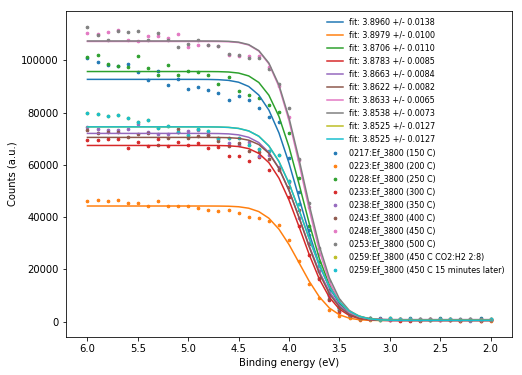

In [133]:
# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
fig = plt.figure(1, figsize=(8,6))
for fermi in fermi_nums:
    fermi_region = exp6.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       scatter=True, 
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 100000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, 
                                   fit_parameters, 
                                   add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)

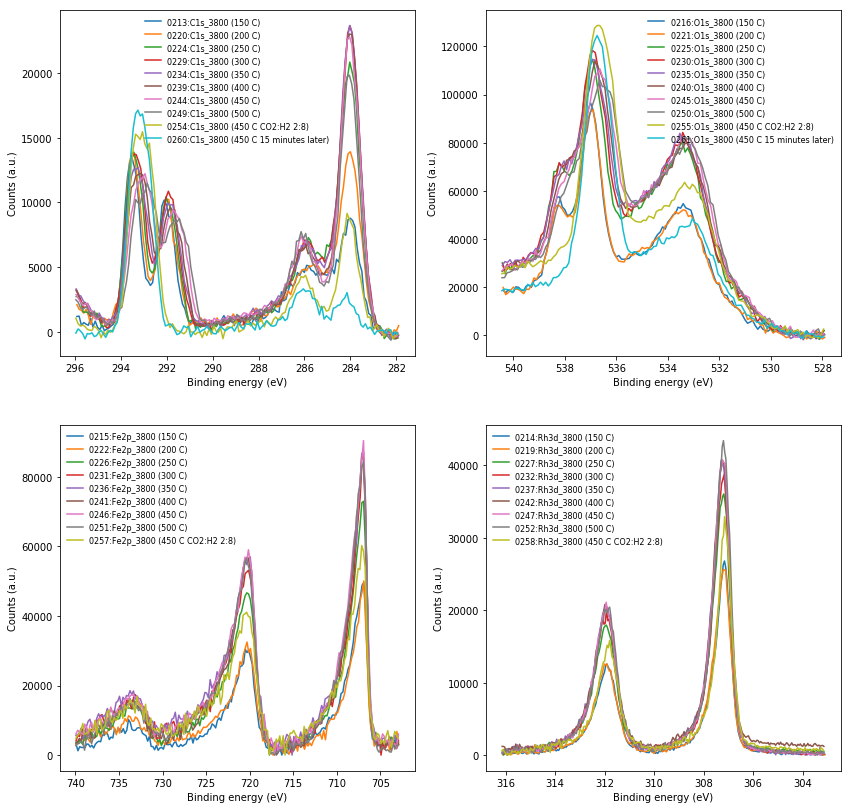

In [134]:
# Adjusting and plotting data overview
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
for i, single_set in enumerate(scan_sets): 
    for j, scan_num in enumerate(single_set):
        scan = exp6.getSpectrum(scan_num).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()
        # Crop Fe2p regions
        if j == 2:
            scan.cropRegion(start=740, stop=703, changesource=True)
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(start=540.5, stop=528, changesource=True)
            helpers.shiftByBackground(scan, start=529, stop=528, y_data="counts", add_column=True)
        # Crop C1s regions
        if j == 0:
            scan.cropRegion(start=296, stop=282, changesource=True)
            helpers.shiftByBackground(scan, start=283, stop=282, y_data="counts", add_column=True)
        # Calculating backgrounds
        if j > 1:
            helpers.calculateShirley(scan, y_data="counts", add_column=True)
            scan.makeFinalColumn("shirleyBG", overwrite=True)
        else:
            scan.makeFinalColumn("bgshifted", overwrite=True)        
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
#         helpers.calculateShirley(scan, y_data="counts", add_column=True)
#         helpers.calculateLinearBackground(scan, y_data="shirleyBG", add_column=True)
        # Plotting spectra
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="final", title=False)

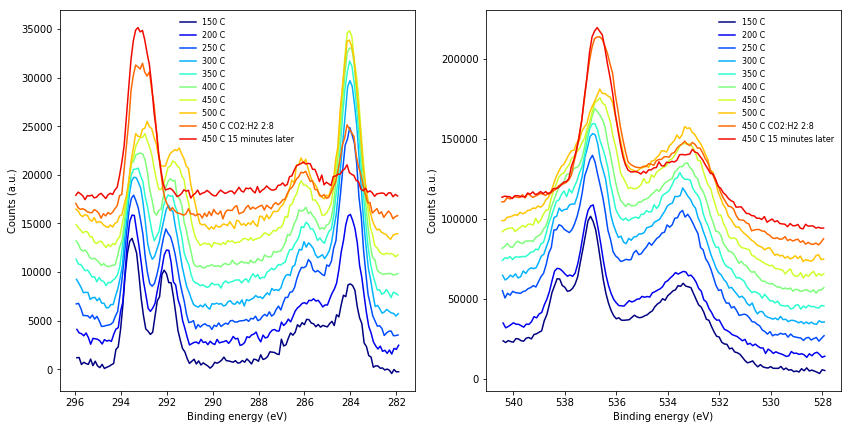

In [136]:
# Focusing on C1s and O1s regions
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = [ax1, ax2]
offset = [1000, 5000]
# Make sure that the colors are consistent through the experiment and that they
# are not repeated
NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i, single_set in enumerate(scan_sets): 
    for j, scan_file in enumerate(single_set[0:2]):
        scan = exp6.getSpectrum(scan_file).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
        #helpers.calculateShirley(scan, y_data="counts", add_column=True)
#         if j == 0:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[296,295],[282.7,282]],
#                                   add_column=True)      
#         if j == 1:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[540,539],[528.7,528]],
#                                   add_column=True) 
        #helpers.calculateLinearBackground(scan, y_data="linearBG", add_column=True)
#         helpers.normalize(scan, y_data="linearBG", add_column=True)
#         scan.makeFinalColumn("normalized", overwrite=True)
        # Plotting spectra
        helpers.plotRegion(scan, 
                           figure=fig.number, 
                           ax=ax[j], 
                           y_offset=offset[j]*(2*i+j),
                           log_scale=False,
                           y_data="final", 
                           label=f"{scan.getConditions('Temperature')}", 
                           title=False)

## <font color ='blue'>Seventh experiment CO : CO2 : H2 = 1 : 4 : 5 at ~200 mbar</font>

In [137]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0266",
    "0272",
    "0277",
    "0282"
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0262", "0263", "0264", "0265"],
    ["0267", "0268", "0269", "0271"],
    ["0273", "0274", "0275", "0276"],
    ["0278", "0279", "0280", "0281"]
]
conditions = [
    {"Temperature": "450 C"},
    {"Temperature": "400 C"},
    {"Temperature": "350 C"},
    {"Temperature": "300 C"}
]

# Create an Experiment object to store spectra specified above
exp7 = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_3800)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp7.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_3800)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            exp7.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

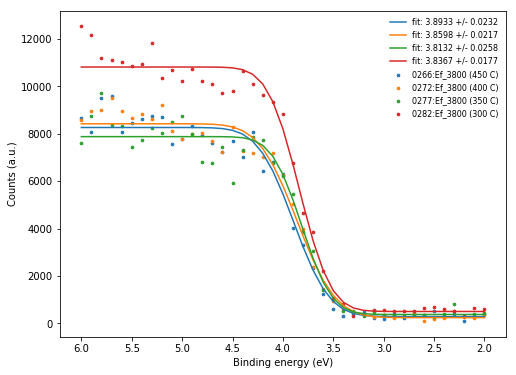

In [138]:
# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
fig = plt.figure(1, figsize=(8,6))
for fermi in fermi_nums:
    fermi_region = exp7.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       scatter=True, 
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 10000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, 
                                   fit_parameters, 
                                   add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)

0275:Fe2p_3800 - Background calculation failed due to excessive iterations
0280:Fe2p_3800 - Background calculation failed due to excessive iterations


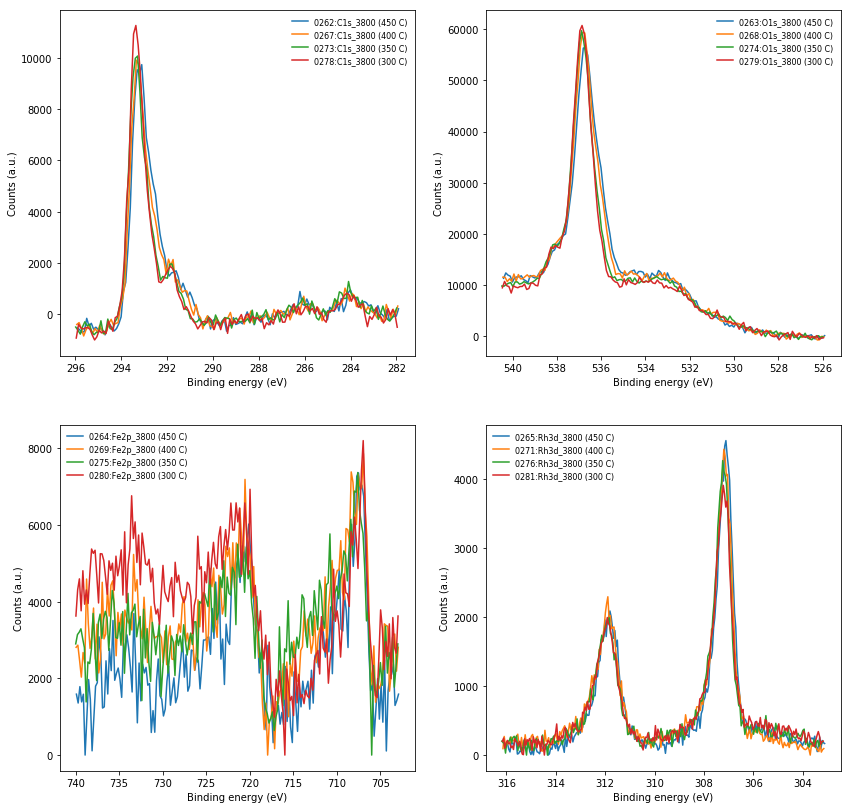

In [139]:
# Adjusting and plotting data overview
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
for i, single_set in enumerate(scan_sets): 
    for j, scan_num in enumerate(single_set):
        scan = exp7.getSpectrum(scan_num).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()       
        # Crop Fe2p regions
        if j == 2:
            scan.cropRegion(start=740, stop=703, changesource=True)
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(start=540.5, stop=526, changesource=True)
            helpers.shiftByBackground(scan, start=528, stop=526, y_data="counts", add_column=True)
        # Crop C1s regions
        if j == 0:
            scan.cropRegion(start=296, stop=282, changesource=True)
            helpers.shiftByBackground(scan, start=283, stop=282, y_data="counts", add_column=True)
        # Calculating backgrounds
        if j > 1:
            helpers.calculateShirley(scan, y_data="counts", add_column=True)
            scan.makeFinalColumn("shirleyBG", overwrite=True)
        else:
            scan.makeFinalColumn("bgshifted", overwrite=True)
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
#         helpers.calculateShirley(scan, y_data="counts", add_column=True)
#         helpers.calculateLinearBackground(scan, y_data="shirleyBG", add_column=True)
        # Plotting spectra
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="final", title=False)

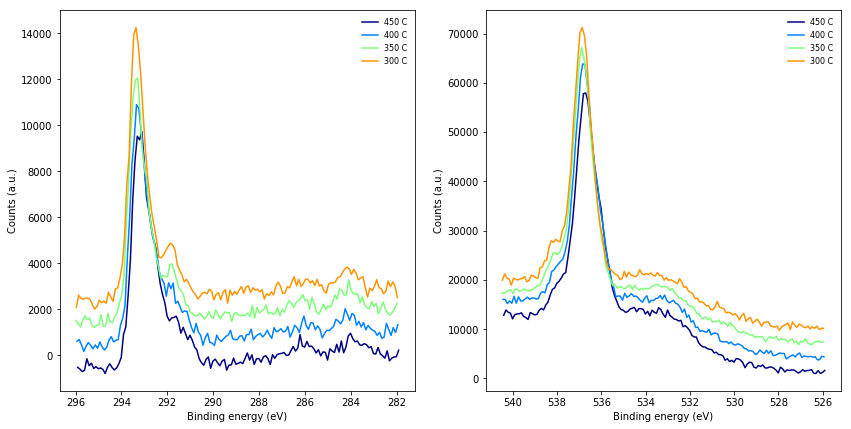

In [143]:
# Focusing on C1s and O1s regions
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = [ax1, ax2]
offset = [500, 1500]
# Make sure that the colors are consistent through the experiment and that they
# are not repeated
NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i, single_set in enumerate(scan_sets): 
    for j, scan_file in enumerate(single_set[0:2]):
        scan = exp7.getSpectrum(scan_file).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
        #helpers.calculateShirley(scan, y_data="counts", add_column=True)
#         if j == 0:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[296,295],[282.7,282]],
#                                   add_column=True)      
#         if j == 1:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[540,539],[528.7,528]],
#                                   add_column=True) 
        #helpers.calculateLinearBackground(scan, y_data="linearBG", add_column=True)
#         helpers.normalize(scan, y_data="linearBG", add_column=True)
#         scan.makeFinalColumn("normalized", overwrite=True)
        # Plotting spectra
        helpers.plotRegion(scan, 
                           figure=fig.number, 
                           ax=ax[j], 
                           y_offset=offset[j]*(2*i+j),
                           log_scale=False,
                           y_data="final", 
                           label=f"{scan.getConditions('Temperature')}", 
                           title=False)

## <font color ='blue'>Eight experiment CO : CO2 : H2 = 1 : 2 : 7 at ~150 mbar</font>

In [144]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0287",
    "0292",
    "0297",
    "0302"
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0283", "0284", "0285", "0286"],
    ["0288", "0289", "0290", "0291"],
    ["0293", "0294", "0295", "0296"],
    ["0298", "0299", "0300", "0301"]
]
conditions = [
    {"Temperature": "450 C"},
    {"Temperature": "400 C"},
    {"Temperature": "350 C"},
    {"Temperature": "300 C"}
]

# Create an Experiment object to store spectra specified above
exp8 = Experiment()
# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]),
                        conditions=conditions[i],
                        excitation_energy=p22_energy_3800)
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        if (len(spectrum.getRegions()) == 1):
            spectrum.getRegion().setFermiFlag()
        else:
            print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")
        exp8.addSpectrum(spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{numstr}.txt"]),
                            conditions=conditions[i],
                            excitation_energy=p22_energy_3800)
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            exp8.addSpectrum(spectrum)
            if len(spectrum.getRegions()) > 1:
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions())} regions")

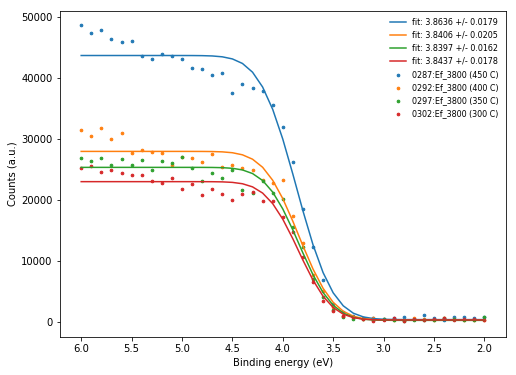

In [145]:
# Adjusting and plotting Fermi regions
shifts = [] # Contains energy shifts for every Fermi edge
gauss_fwhms = [] # Equipment gauss widening based on the Fermi edge
fig = plt.figure(1, figsize=(8,6))
for fermi in fermi_nums:
    fermi_region = exp8.getSpectrum(fermi).getRegion()
    fermi_region.invertToBinding()
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       scatter=True, 
                       title=False)

    fit_parameters = [1, 3.8, 0.2, 10000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi_region, 
                                   fit_parameters, 
                                   add_column=True)
    shifts.append([fit_res[0][1], fit_res[1][1]])
    # a2 parameter of the complementary error function is related to the
    # sigma parameter of the gaussian that can be constructed to describe
    # the widening of ideal step function. 
    # FWHM_gauss = 2*sqrt(ln2)*a2
    # FWHM_gauss = 2*sqrt(2ln2)*sigma
    gauss_fwhms.append([2*(math.log(2))**(.5)*abs(fit_res[0][2]), fit_res[1][2]])
    helpers.plotRegion(fermi_region, 
                       figure=fig.number, 
                       y_data="fitFermi", 
                       label=f"fit: {fit_res[0][1]:.4f} +/- {fit_res[1][1]:.4f}", 
                       title=False)

0290:Fe2p_3800 - Background calculation failed due to excessive iterations


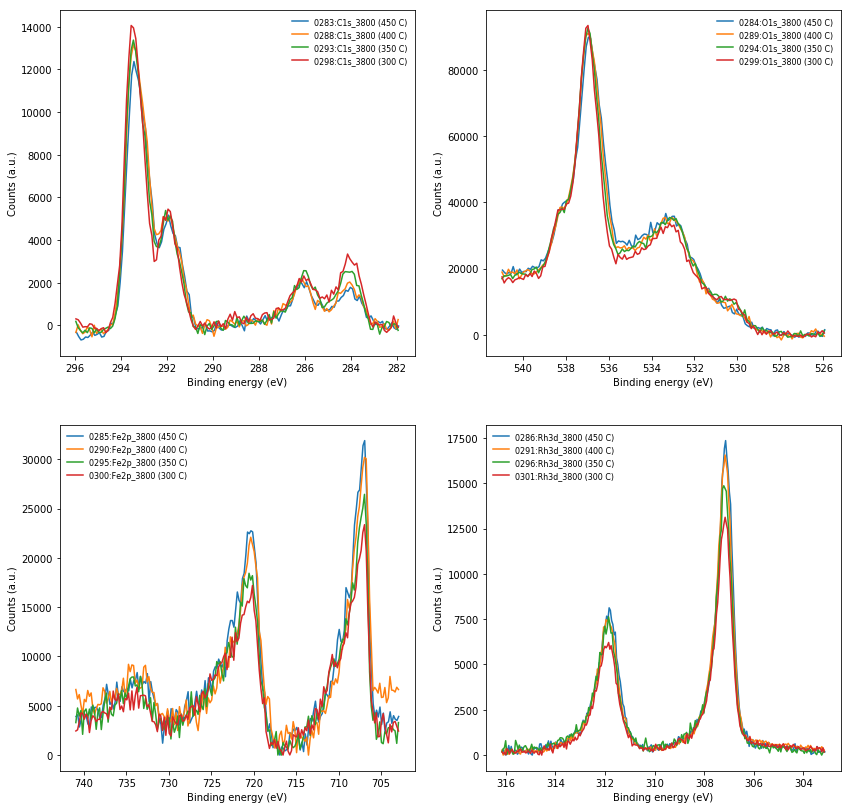

In [146]:
# Adjusting and plotting data overview
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
for i, single_set in enumerate(scan_sets): 
    for j, scan_num in enumerate(single_set):
        scan = exp8.getSpectrum(scan_num).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()        
        # Crop Fe2p regions
        if j == 2:
            scan.cropRegion(start=741, stop=703, changesource=True)
        # Crop O1s regions
        if j == 1:
            scan.cropRegion(start=541, stop=526, changesource=True)
            helpers.shiftByBackground(scan, start=528, stop=526, y_data="counts", add_column=True)
        # Crop C1s regions
        if j == 0:
            scan.cropRegion(start=296, stop=282, changesource=True)
            helpers.shiftByBackground(scan, start=283, stop=282, y_data="counts", add_column=True)
        # Calculating backgrounds
        if j > 1:
            helpers.calculateShirley(scan, y_data="counts", add_column=True)
            scan.makeFinalColumn("shirleyBG", overwrite=True)
        else:
            scan.makeFinalColumn("bgshifted", overwrite=True)
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
#         helpers.calculateShirley(scan, y_data="counts", add_column=True)
#         helpers.calculateLinearBackground(scan, y_data="shirleyBG", add_column=True)
        # Plotting spectra
        helpers.plotRegion(scan, figure=fig.number, ax=ax[j], y_data="final", title=False)

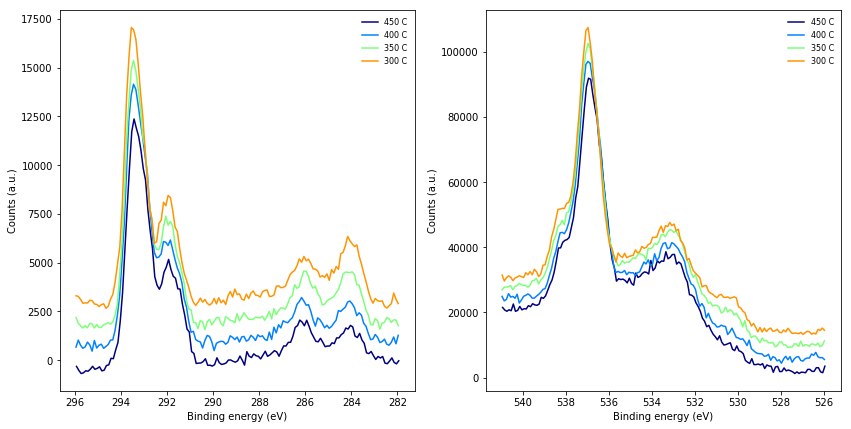

In [149]:
# Focusing on C1s and O1s regions
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = [ax1, ax2]
offset = [500, 2000]
# Make sure that the colors are consistent through the experiment and that they
# are not repeated
NUM_COLORS = len(scan_sets)
cmap = plt.get_cmap('jet')
for axis in ax:
    axis.set_prop_cycle('color', [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i, single_set in enumerate(scan_sets): 
    for j, scan_file in enumerate(single_set[0:2]):
        scan = exp8.getSpectrum(scan_file).getRegion()
        if not scan.isEnergyCorrected():
            scan.correctEnergyShift(shifts[i][0])
        if not scan.isSweepsNormalized():
            scan.normalizeBySweeps()
        scan.invertToBinding()
        # Calculating backgrounds
        #helpers.smoothen(scan, y_data="counts", interval=3, add_column=True)
        #helpers.calculateShirley(scan, y_data="counts", add_column=True)
#         if j == 0:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[296,295],[282.7,282]],
#                                   add_column=True)      
#         if j == 1:
#             helpers.calculateLinearBackground(scan, 
#                                   y_data="shirleyBG", 
#                                   manual_bg=[[541,539.7],[528.7,528]],
#                                   add_column=True) 
        #helpers.calculateLinearBackground(scan, y_data="linearBG", add_column=True)
#         helpers.normalize(scan, y_data="linearBG", add_column=True)
#         scan.makeFinalColumn("normalized", overwrite=True)
        # Plotting spectra
        helpers.plotRegion(scan, 
                           figure=fig.number, 
                           ax=ax[j], 
                           y_offset=offset[j]*(2*i+j),
                           log_scale=False,
                           y_data="final", 
                           label=f"{scan.getConditions('Temperature')}", 
                           title=False)